# Assignment 4 in System Genetics - Gil Sasson & Tomer Schweid

## Loading Modules

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os
import pickle
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.metrics import log_likelihood_score

## Loading Data
We are using the eQTLs and their associated genes from the liver and myeloid datasets from the previous assignment. We are also using the QTLs and their associated phenotype from the second assignment. Our phenotype is: Infectious disease, immune function: H5N1 influenza A virus mortality rate 30 days after infection (Boon-Webby Trait 1) [% death] (phenotype_id = 787). 


In [9]:
directory_path = '.' + os.sep + 'data'
# Load QTLs from hw2
qtls = pd.read_csv(directory_path + os.sep + 'significant_QTLs.txt', sep=",")
# Load the eQTLs and genes from dataframes from hw3
with open(os.path.join(directory_path, 'eQTLs_Myeloid Dataset.pkl'), 'rb') as file:
    eqtls_myeloid = pickle.load(file)
with open(os.path.join(directory_path, 'eQTLs_Liver Dataset.pkl'), 'rb') as file:
    eqtls_liver = pickle.load(file)
with open(os.path.join(directory_path, 'genes_Myeloid Dataset.pkl'), 'rb') as file:
    genes_myeloid = pickle.load(file)
with open(os.path.join(directory_path, 'genes_Liver Dataset.pkl'), 'rb') as file:
    genes_liver = pickle.load(file)
analysis_liver = pd.read_csv(directory_path + os.sep + 'analysis_liver.csv')
analysis_myeloid = pd.read_csv(directory_path + os.sep + 'analysis_myeloid.csv')
genotype_df = pd.read_csv(directory_path + os.sep + 'genotypes.txt', sep=",")
phenotype_df = pd.read_csv(directory_path + os.sep + 'phenotypes.txt', sep=",")

### HW2 - QTLs analysis
In the second assigment we analyzed BXD mice strains' genotypes data to find a significant association between SNPs and our phenotype. After correcting for multiple testing we found 19 QTLs that are associated with the phenotype.

In [10]:
qtls.drop(columns=['-log(p)', 'p', 'is_significant?', 'corrected_p'], inplace=True)
qtls

,SNP,Chromosome,Position
0,rs3699934,2,35957196.0
1,rs13476435,2,37285190.0
2,rs3709811,2,37512633.0
3,rs13476448,2,39670020.0
4,CEL-2_39972578,2,39868107.0
5,CEL-2_40063411,2,39958940.0
6,rs6323034,2,40196435.0
7,rs6324652,2,40655059.0
8,rs13476452,2,40783490.0
9,rs4136879,2,41295574.0


### HW3 - eQTLs analysis
In the third assigment we analyzed the BXD mice strains' genotypes data to find eQTLs that are associated with genes expression levels in two expression datasets: myeloid and liver. In the myeloid dataset we found 673 unique eQTLs and in the liver dataset we found 1,435 unique eQTLs. Some of the eQTLs are associated with multiple genes, consequently we found 394 cis-acting snps and 961 trans-acting snps in the myeloid dataset and 1,799 cis-acting snps and 4,910 trans-acting snps in the liver dataset.

In [11]:
eqtls_myeloid

,snp,chromosome,position,associated genes,associated genes count,relative position
0,rs6404906,4,133563658,"[0610009K11Rik, 4931440N07Rik, AI838661, Cd52,...",8,0.858320
1,rs13478001,4,135998441,"[0610009K11Rik, 4931440N07Rik, AI838661, Cd52,...",8,0.873967
2,rs13478002,4,136230564,"[0610009K11Rik, 1110005F07Rik, 4930523M17Rik, ...",9,0.875459
3,rs6234904,4,138152372,"[0610009K11Rik, 1110005F07Rik, AI838661, C7926...",7,0.887809
4,rs13478021,4,140166294,"[0610009K11Rik, 1110005F07Rik, AI838661, C7926...",7,0.900751
...,...,...,...,...,...,...
668,gnf12.035.312,12,37595107,[Zfp277],1,0.310044
669,mCV23299449,12,40250123,[Zfp277],1,0.331940
670,rs13481414,12,43219217,[Zfp277],1,0.356426
671,rs3726096,12,45455649,[Zfp277],1,0.374870


### HW3 - Combined Results
After both analyses we found that 4/19 QTLs are also eQTLs and 16/19 are close (or in the same loci) to eQTLs in the myeloid cells. In the liver dataset we found that 7/19 QTLs are also eQTLs and 19/19 are close (or in the same loci) to eQTLs. This information could suggest that the QTLs are affecting the phenotype through gene expression regulation in those QTLs and in those tissues. But, there could be also two other possible relations: 1.The QTLs are affecting gene expression and the phenotype independently. 2. The QTL is affecting gene experssion through the phenotype.

In [12]:
# Define a function that checks if a QTL is close to an eQTL
def qtl_near_eqtl(row, eqtls):
    """This function gets a row from a QTL dataframe and a dataframe with eQTLs and returns a list of eQTLs that are close to the QTL"""
    cutoff = 2000000 # 2Mbp was defined in the previous assignment as the cutoff between cis-trans eQTL
    qtl_chromosome = row['Chromosome'] # Extracting QTL chromosome
    qtl_position = row['Position']
    snps = []
    # Iterate over all eQTLs
    for index, eqtl in eqtls.iterrows():
        eqtl_name = eqtl['snp']
        eqtl_chromosome = eqtl['chromosome']
        eqtl_positions = eqtl['position']
        # Check if the QTL and eQTL are on the same chromosome
        if qtl_chromosome == eqtl_chromosome:
            # If the distance is less than the cutoff, they are close
            if abs(qtl_position - eqtl_positions) <= cutoff:
                snps.append(eqtl_name)
    return snps

In [13]:
# Check which QTLs are close to eQTLs
qtls['near_eqtl_myeloid'] = qtls.apply(qtl_near_eqtl, eqtls=eqtls_myeloid, axis=1)
qtls['near_eqtl_liver'] = qtls.apply(qtl_near_eqtl, eqtls=eqtls_liver, axis=1)
qtls[['SNP', 'near_eqtl_myeloid', 'near_eqtl_liver']]

,SNP,near_eqtl_myeloid,near_eqtl_liver
0,rs3699934,"[rs13476425, rs3699934]","[rs3699934, rs13476427]"
1,rs13476435,[rs3699934],[rs3699934]
2,rs3709811,[rs3699934],[rs3699934]
3,rs13476448,[rs13476448],"[rs13476448, rs13476456]"
4,CEL-2_39972578,[rs13476448],"[rs13476448, rs13476456]"
5,CEL-2_40063411,[rs13476448],"[rs13476448, rs13476456]"
6,rs6323034,[rs13476448],"[rs13476448, rs13476456]"
7,rs6324652,"[rs13476448, rs13476459]","[rs13476448, rs13476456]"
8,rs13476452,"[rs13476448, rs13476459]","[rs13476448, rs13476456, rs6288325]"
9,rs4136879,"[rs13476448, rs13476459]","[rs13476448, rs13476456, rs6288325]"


In [14]:
# Drop QTLs that are not close to any eQTL
qtls_analysis = qtls[qtls['near_eqtl_myeloid'].apply(lambda x: len(x) > 0) | qtls['near_eqtl_liver'].apply(lambda x: len(x) > 0)]
relevant_eqtls = qtls['near_eqtl_liver'].to_list()
relevant_eqtls = [snp for sublist in relevant_eqtls for snp in sublist]
relevant_eqtls = set(relevant_eqtls)
relevant_eqtls

{'CEL-2_50605053',
 'UT_17_75.437568',
 'rs13476427',
 'rs13476448',
 'rs13476456',
 'rs13479451',
 'rs13483106',
 'rs13483110',
 'rs3656948',
 'rs3663088',
 'rs3699934',
 'rs3711721',
 'rs6278585',
 'rs6288325'}

In [15]:
# Define a function that gets the genes that are close to the eQTL
def get_cis_genes(eqtls_df, genes_df, relevant_eqtls):
    """This function gets a dataframe with the eQTLs, a dataframe with the genes, and a set of relevant eQTLs and returns the eQTLs dataframe with a column that contains the genes that are close to the eQTL"""
    eqtls_df['cis genes'] = pd.Series([[] for _ in range(len(eqtls_df.index))])
    for index, row in eqtls_df[eqtls_df['snp'].isin(relevant_eqtls)].iterrows():
        eqtl_position = row['position']
        associated_genes = row['associated genes']
        updated_genes = []
        for gene in associated_genes:
            gene_data = genes_df[genes_df['gene'] == gene]
            if gene_data.empty:
                continue
            elif gene_data['chromosome'].values[0] != row['chromosome']:
                continue
            gene_start = gene_data['start position'].values[0]
            gene_end = gene_data['end position'].values[0]
            if abs(gene_start - eqtl_position) <= 2000000 or abs(gene_end - eqtl_position) <= 2000000:
                updated_genes.append(gene)
        eqtls_df.at[index, 'cis genes'] = updated_genes
    return eqtls_df

# Ad the cis genes column to the eQTLs dataframes
eqtls_liver = get_cis_genes(eqtls_liver, genes_liver, relevant_eqtls)
eqtls_myeloid = get_cis_genes(eqtls_myeloid, genes_myeloid, relevant_eqtls)

eqtls_liver

,snp,chromosome,position,associated genes,associated genes count,relative position,cis genes
0,rs3699325,8,17328897,[1-acylglycerol-3-phosphate O-acyltransferase ...,2,0.131571,[]
1,rs3699118,8,18512782,[1-acylglycerol-3-phosphate O-acyltransferase ...,3,0.140560,[]
2,rs4227066,8,22905816,[1-acylglycerol-3-phosphate O-acyltransferase ...,3,0.173914,[]
3,gnf08.020.641,8,23259030,[1-acylglycerol-3-phosphate O-acyltransferase ...,4,0.176596,[]
4,rs13479651,8,25314442,[1-acylglycerol-3-phosphate O-acyltransferase ...,4,0.192202,[]
...,...,...,...,...,...,...,...
1430,rs13477030,3,27500205,[zinc finger protein 639],1,0.172309,[]
1431,gnf03.025.352,3,28293134,[zinc finger protein 639],1,0.177277,[]
1432,rs6260196,3,28626877,[zinc finger protein 639],1,0.179369,[]
1433,rs3661905,3,31752412,[zinc finger protein 639],1,0.198952,[]


In [16]:
# Create a dictionary that maps each QTL to its associated genes
def qtl_gene_dict(qtls, eqtls_analysis, tissue='liver'):
    """This function gets a dataframe with the QTLs, a dataframe with the eQTLs, and a tissue name and returns a dictionary that maps each QTL to its associated genes"""
    qtl_gene_dict = {}
    for index, row in qtls.iterrows():
        qtl_name = row['SNP']
        qtl_gene_dict[qtl_name] = []
        relevant_eqtls = row[f'near_eqtl_{tissue}']
        for eqtl in relevant_eqtls:
            eqtl_data = eqtls_analysis[eqtls_analysis['snp'] == eqtl]
            if eqtl_data.empty:
                continue
            qtl_gene_dict[qtl_name].extend(eqtl_data['cis genes'].values[0])
        if len(qtl_gene_dict[qtl_name]) == 0:
            del qtl_gene_dict[qtl_name] 
    qtl_gene_dict = {k: list(set(v)) for k, v in qtl_gene_dict.items()}
    return qtl_gene_dict

qtl_gene_dict_liver = qtl_gene_dict(qtls, eqtls_liver)
qtl_gene_dict_myeloid = qtl_gene_dict(qtls, eqtls_myeloid, tissue='myeloid')
print(qtl_gene_dict_liver)

{'rs3699934': ['zinc finger and BTB domain containing 43', 'hemolytic complement'], 'rs13476435': ['hemolytic complement'], 'rs3709811': ['hemolytic complement'], 'CEL-2_50605053': ['Rap1 interacting factor 1 homolog (yeast)'], 'rs13476490': ['Rap1 interacting factor 1 homolog (yeast)'], 'rs13479451': ['olfactomedin-like 1'], 'rs3724540': ['olfactomedin-like 1'], 'rs6386601': ['olfactomedin-like 1'], 'rs13483110': ['fasciculation and elongation protein zeta 2 (zygin II)', 'protein kinase D3', 'xanthine dehydrogenase', 'cysteine rich transmembrane BMP regulator 1 (chordin like)'], 'rs3656948': ['fasciculation and elongation protein zeta 2 (zygin II)', 'protein kinase D3', 'xanthine dehydrogenase', 'cysteine rich transmembrane BMP regulator 1 (chordin like)'], 'rs6278585': ['fasciculation and elongation protein zeta 2 (zygin II)', 'protein kinase D3', 'xanthine dehydrogenase', 'cysteine rich transmembrane BMP regulator 1 (chordin like)'], 'rs3717212': ['fasciculation and elongation prote

In [17]:
# Set the index of the analysis dataframes to the gene name
analysis_liver = analysis_liver.set_index('GENE_NAME')
analysis_myeloid = analysis_myeloid.set_index('Symbol')

# Create the analysis dataframe
def create_analysis_df(qtl_gene_dict, values_df, genotypes_df):
    """This function gets a dictionary that maps SNPs to genes, a dataframe with the gene expression values, and a dataframe with the genotypes and returns a dataframe with the relevant SNPs, genes, and the phenotype values"""
    genotypes_df = genotypes_df.set_index('Locus')
    genotypes_df.drop(columns=['0', "Chr_Build37", "Build37_position"], inplace=True)
    relevant_strains = values_df.columns
    genotypes_df = genotypes_df.loc[:, relevant_strains]
    analysis_df = pd.DataFrame(index=values_df.columns)
    # Add the SNPs and genes columns
    for snp in qtl_gene_dict.keys():
        analysis_df[snp] = genotypes_df.loc[snp]
        for gene in qtl_gene_dict[snp]:
            analysis_df[gene] = values_df.loc[gene]
    # Add the phenotype column
    analysis_df['Phenotype'] = phenotype_df.iloc[787, :]
    analysis_df = analysis_df.dropna()
    return analysis_df

analysis_df_liver = create_analysis_df(qtl_gene_dict_liver, analysis_liver, genotype_df)
analysis_df_myeloid = create_analysis_df(qtl_gene_dict_myeloid, analysis_myeloid, genotype_df)

analysis_df_liver.head()

,rs3699934,zinc finger and BTB domain containing 43,hemolytic complement,rs13476435,rs3709811,CEL-2_50605053,Rap1 interacting factor 1 homolog (yeast),rs13476490,rs13479451,olfactomedin-like 1,...,rs6386601,rs13483110,fasciculation and elongation protein zeta 2 (zygin II),protein kinase D3,xanthine dehydrogenase,cysteine rich transmembrane BMP regulator 1 (chordin like),rs3656948,rs6278585,rs3717212,Phenotype
BXD1,2,0.6935,1.1480,2,2,2,-0.127167,2,0,0.8930,...,0,0,-0.1370,0.60525,0.7805,-0.8140,0,0,0,66.7
BXD2,0,0.6975,1.3790,0,0,0,-0.537333,0,0,0.5475,...,0,0,-0.1055,0.15700,1.1085,-1.0370,0,0,0,0.0
BXD5,2,0.5300,-1.2235,2,2,2,-0.339667,2,2,1.7195,...,2,2,-1.1765,-0.07650,0.0590,-1.2140,2,2,2,100.0
BXD6,0,0.7165,1.4045,0,0,0,-0.864667,0,0,1.0385,...,0,0,-0.2130,0.83800,1.0005,-0.9225,0,0,0,50.0
BXD8,0,0.9320,1.4655,0,0,0,-0.279667,0,0,0.9875,...,0,0,-1.3090,1.08775,1.2025,-1.6340,0,0,0,0.0


In [18]:
# Define the causality test function
def causality_test(data, snp, gene):
    """This function gets a dataframe and two columns names, one for the snp and one for the gene, and returns the log likelihood of the 3 possible Bayesian Networks structures
    1. SNP -> Gene -> Phenotype
    2. SNP -> Phenotype -> Gene
    3. Phenotype <- SNP -> Gene
    """
    triplet_df = data[[snp, gene, 'Phenotype']]
    # Define the 3 possible structures for the Bayesian Network
    # 1. SNP -> Gene -> Phenotype
    edges_1 = [(snp, gene), (gene, 'Phenotype')]
    # 2. SNP -> Phenotype -> Gene
    edges_2 = [(snp, 'Phenotype'), ('Phenotype', gene)]
    # 3. Phenotype <- SNP -> Gene
    edges_3 = [(snp, gene), (snp, 'Phenotype')]
            
    # Create the models
    model_1 = BayesianNetwork(edges_1)
    model_2 = BayesianNetwork(edges_2)
    model_3 = BayesianNetwork(edges_3)
    
    # Fit the models
    model_1.fit(triplet_df, estimator=MaximumLikelihoodEstimator)
    model_2.fit(triplet_df, estimator=MaximumLikelihoodEstimator)
    model_3.fit(triplet_df, estimator=MaximumLikelihoodEstimator)
    
    # Calculate the log likelihood
    log_likelihood_1 = log_likelihood_score(model_1, triplet_df)
    log_likelihood_2 = log_likelihood_score(model_2, triplet_df)
    log_likelihood_3 = log_likelihood_score(model_3, triplet_df)
    
    return log_likelihood_1, log_likelihood_2, log_likelihood_3


# Define a function that runs the causality test for all SNP-Gene pairs
def run_causality_tests(data, snp_gene_pairs):
    """This function gets a dataframe and a dictionary that maps SNPs to genes and returns the log likelihood of the 3 possible Bayesian Networks structures for each SNP-Gene pair"""
    results = {}
    for snp in snp_gene_pairs.keys():
        for gene in snp_gene_pairs[snp]:
            results[(snp, gene)] = causality_test(data, snp, gene)
    return results

In [19]:
# Run the causality tests for the liver dataset
results_liver = run_causality_tests(analysis_df_liver, qtl_gene_dict_liver)
results_liver = pd.DataFrame(results_liver).T
results_liver.columns = ['model_1', 'model_2', 'model_3']
# Add a column for the best model
results_liver['best_model'] = results_liver.idxmax(axis=1)
results_liver.head(10)

model_1  \
rs3699934      zinc finger and BTB domain containing 43           -142.878904   
               hemolytic complement                               -141.492610   
rs13476435     hemolytic complement                               -141.492610   
rs3709811      hemolytic complement                               -141.492610   
CEL-2_50605053 Rap1 interacting factor 1 homolog (yeast)          -142.878904   
rs13476490     Rap1 interacting factor 1 homolog (yeast)          -142.878904   
rs13479451     olfactomedin-like 1                                -142.878904   
rs3724540      olfactomedin-like 1                                -142.878904   
rs6386601      olfactomedin-like 1                                -142.878904   
rs13483110     fasciculation and elongation protein zeta 2 (zy... -141.492610   

                                                                      model_2  \
rs3699934      zinc finger and BTB domain containing 43           -156.551354   
               hemolytic complement                               -155.165060   
rs13476435     hemolytic complement                               -155.165060   
rs3709811      hemolytic complement                               -155.165060   
CEL-2_50605053 Rap1 interacting factor 1 homolog (yeast)          -158.984145   
rs13476490     Rap1 interacting factor 1 homolog (yeast)          -158.984145   
rs13479451     olfactomedin-like 1                                -158.357767   
rs3724540      olfactomedin-like 1                                -158.357767   
rs6386601      olfactomedin-like 1                                -158.357767   
rs13483110     fasciculation and elongation protein zeta 2 (zy... -160.198088   

                                                                      model_3  \
rs3699934      zinc finger and BTB domain containing 43           -211.125438   
               hemolytic complement                               -209.739144   
rs13476435     hemolytic complement                               -209.739144   
rs3709811      hemolytic complement                               -209.739144   
CEL-2_50605053 Rap1 interacting factor 1 homolog (yeast)          -213.352331   
rs13476490     Rap1 interacting factor 1 homolog (yeast)          -213.352331   
rs13479451     olfactomedin-like 1                                -205.060681   
rs3724540      olfactomedin-like 1                                -205.060681   
rs6386601      olfactomedin-like 1                                -205.060681   
rs13483110     fasciculation and elongation protein zeta 2 (zy... -213.077303   

                                                                  best_model  
rs3699934      zinc finger and BTB domain containing 43              model_1  
               hemolytic complement                                  model_1  
rs13476435     hemolytic complement                                  model_1  
rs3709811      hemolytic complement                                  model_1  
CEL-2_50605053 Rap1 interacting factor 1 homolog (yeast)             model_1  
rs13476490     Rap1 interacting factor 1 homolog (yeast)             model_1  
rs13479451     olfactomedin-like 1                                   model_1  
rs3724540      olfactomedin-like 1                                   model_1  
rs6386601      olfactomedin-like 1                                   model_1  
rs13483110     fasciculation and elongation protein zeta 2 (zy...    model_1

In [20]:
# Run the causality tests for the myeloid dataset
results_myeloid = run_causality_tests(analysis_df_myeloid, qtl_gene_dict_myeloid)
results_myeloid = pd.DataFrame(results_myeloid).T
results_myeloid.columns = ['model_1', 'model_2', 'model_3']
results_myeloid['best_model'] = results_myeloid.idxmax(axis=1)
results_myeloid.head(10)

,,model_1,model_2,model_3,best_model
rs13479451,Ppfibp2,-63.934971,-69.663599,-91.023267,model_1
rs3724540,Ppfibp2,-63.934971,-69.663599,-91.023267,model_1
rs6386601,Ppfibp2,-63.934971,-69.663599,-91.023267,model_1


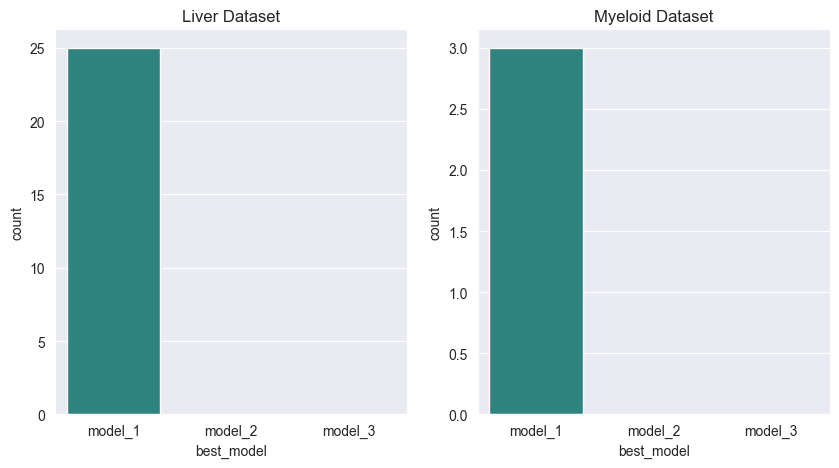

In [27]:
# Count the number of times each model was selected
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=results_liver, x='best_model', order=['model_1', 'model_2', 'model_3'])
plt.title('Liver Dataset')
plt.subplot(1, 2, 2)
sns.countplot(data=results_myeloid, x='best_model', order=['model_1', 'model_2', 'model_3'])
plt.title('Myeloid Dataset')
plt.show()

## Results
It seems that for both datasets the best model is the one where the SNP is the parent of the gene and the gene is the parent of the phenotype. This structure suggests that the SNP is affecting the gene expression and the gene expression is affecting the phenotype. This result is consistent with the hypothesis that the QTLs are affecting the phenotype through gene expression regulation in those QTLs and in those tissues.